In [1]:
# !pip install tensorflow
# !pip install scikit-learn
!pip install optuna
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install timm
# # or for huggingface transformers if you'd like to use that:
!pip install transformers
!pip install matplotlib opencv-python

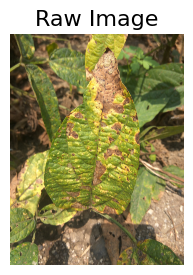

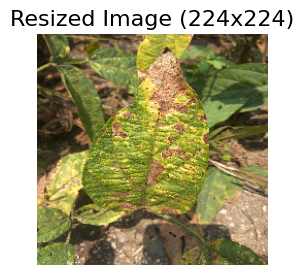

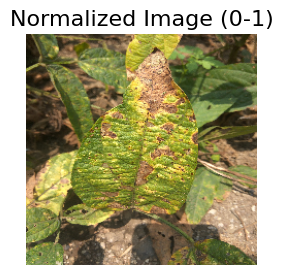

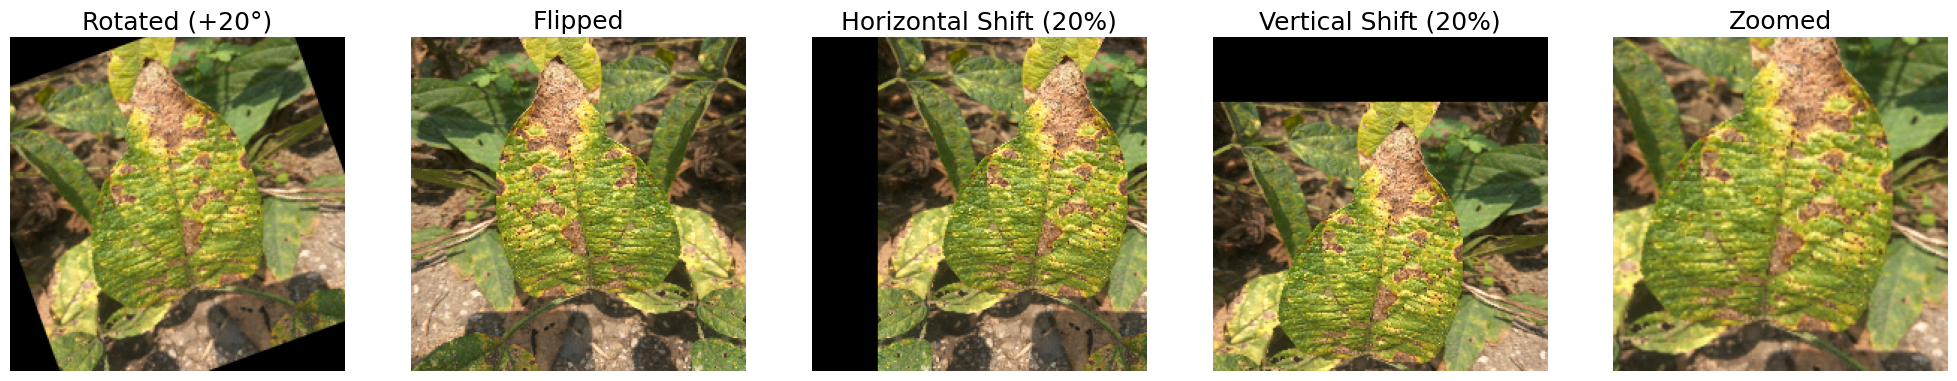

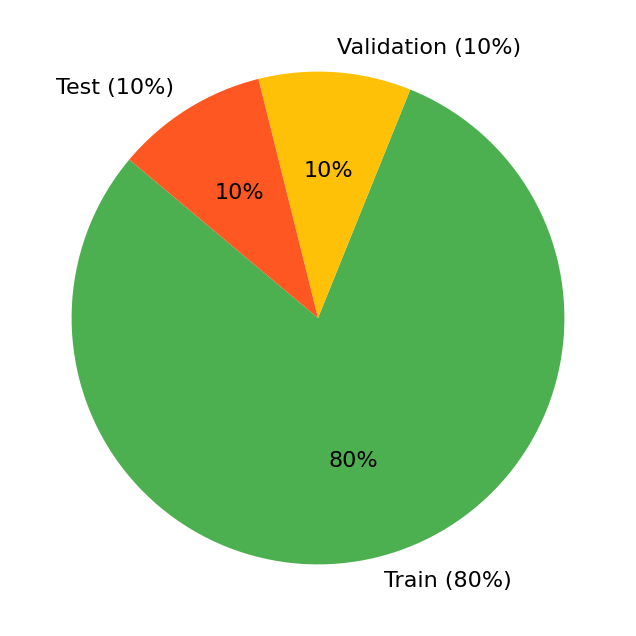

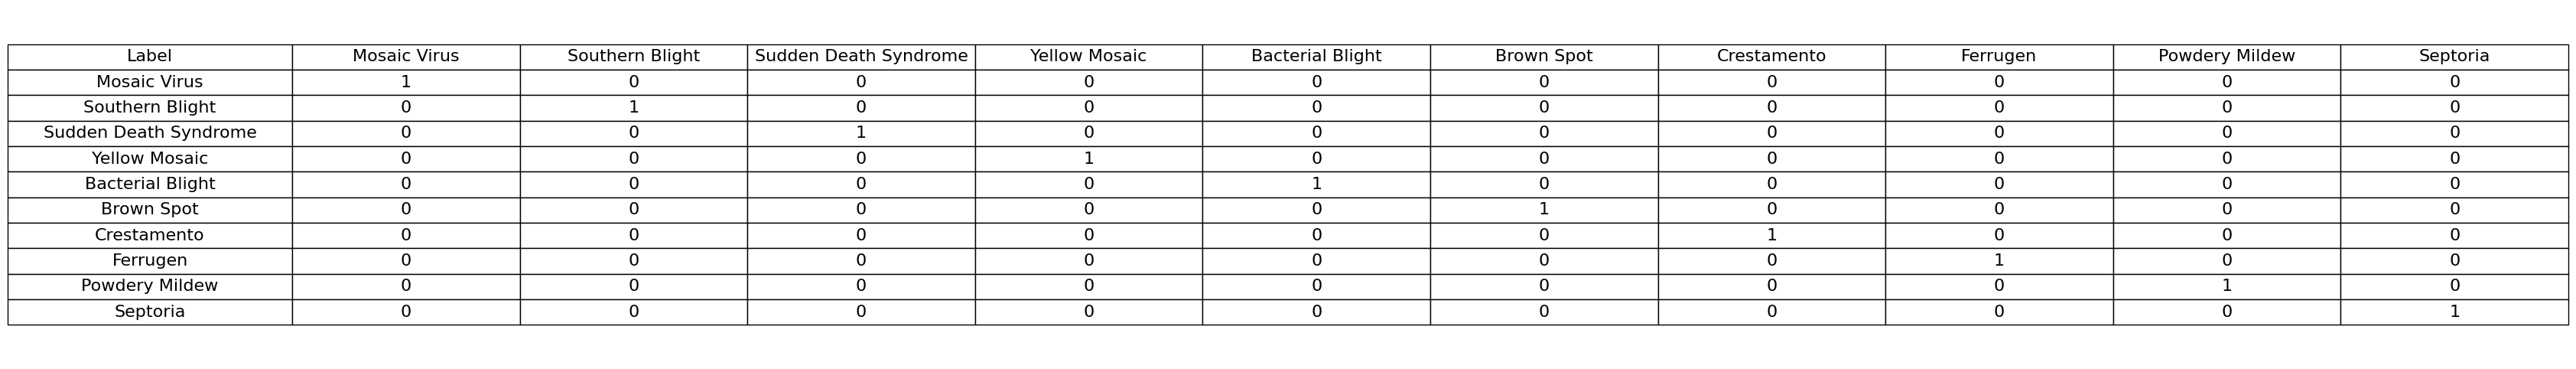

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset directory
dataset_dir = "/kaggle/input/soybean-diseased-leaf-dataset"

# Load a sample image (first image from first class)
def load_sample_image(folder_path, target_size=(224, 224)):
    class_folder = os.path.join(folder_path, os.listdir(folder_path)[7])  # First class
    image_file = os.listdir(class_folder)[0]  # First image
    image_path = os.path.join(class_folder, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, target_size)
    return image, image_resized

# Load sample image
original_image, resized_image = load_sample_image(dataset_dir)

# Font size for better readability
plt.rcParams.update({'font.size': 18})

# 1. Image Acquisition - Raw Image
plt.figure(figsize=(3, 3))
plt.imshow(original_image)
plt.title('Raw Image', fontsize=16)
plt.axis('off')
plt.savefig('1_image_acquisition.png', dpi=300)
plt.show()

# 2. Resized Image
plt.figure(figsize=(3, 3))
plt.imshow(resized_image)
plt.title('Resized Image (224x224)', fontsize=16)
plt.axis('off')
plt.savefig('2_resized_image.png', dpi=300)
plt.show()

# 3. Pixel Normalization (Original vs Normalized)
normalized_image = resized_image / 255.0

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# axes[0].imshow(resized_image)
# axes[0].set_title('Original Image', fontsize=20)
# axes[0].axis('off')

# axes[1].imshow(normalized_image)
# axes[1].set_title('Normalized Image (0-1)', fontsize=20)
# axes[1].axis('off')

plt.figure(figsize=(3, 3))
plt.imshow(normalized_image)
plt.axis('off')
plt.title('Normalized Image (0-1)', fontsize=16)
plt.savefig('3_pixel_normalization.png', dpi=300)
plt.show()

# 4. Data Augmentation Examples (with separate height shift visualization)

def augment_image_with_height_shift(img):
    h, w = img.shape[:2]
    
    # Rotation
    M_rot = cv2.getRotationMatrix2D((w//2, h//2), 20, 1)
    rotated = cv2.warpAffine(img, M_rot, (w, h))

    # Horizontal Flip
    flipped = cv2.flip(img, 1)

    # Horizontal Shift (existing)
    M_shift_horizontal = np.float32([[1, 0, int(0.2 * w)], [0, 1, 0]])
    shifted_horizontal = cv2.warpAffine(img, M_shift_horizontal, (w, h))

    # Height (Vertical) Shift - NEW
    M_shift_vertical = np.float32([[1, 0, 0], [0, 1, int(0.2 * h)]])
    shifted_vertical = cv2.warpAffine(img, M_shift_vertical, (w, h))

    # Zoom (crop center and resize back to original size)
    zoomed = cv2.resize(img[30:h-30, 30:w-30], (w, h))
    
    return [rotated, flipped, shifted_horizontal, shifted_vertical, zoomed]

# Titles for each augmentation
augment_titles = [
    "Rotated (+20°)",
    "Flipped",
    "Horizontal Shift (20%)",
    "Vertical Shift (20%)",  # New
    "Zoomed"
]

# Generate augmented images from the resized image
augmented_images = augment_image_with_height_shift(resized_image)

# Plot all augmentations
fig, axes = plt.subplots(1, 5, figsize=(25, 8))

for i, (img, title) in enumerate(zip(augmented_images, augment_titles)):
    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=18)
    axes[i].axis('off')

# plt.suptitle('Data Augmentation Examples', fontsize=24, weight='bold')
plt.savefig('4_data_augmentation.png', dpi=300)
plt.show()


# 5. Dataset Split Pie Chart
plt.figure(figsize=(8, 8))
plt.pie([80, 10, 10], 
        labels=['Train (80%)', 'Validation (10%)', 'Test (10%)'], 
        colors=['#4CAF50', '#FFC107', '#FF5722'], 
        autopct='%1.0f%%', 
        startangle=140, 
        textprops={'fontsize': 16})
# plt.title('Dataset Split', fontsize=24, weight='bold')
plt.savefig('5_dataset_split.png', dpi=300)
plt.show()

# 6. One-Hot Encoding Example
labels = ['Mosaic Virus', 'Southern Blight', 'Sudden Death Syndrome', 'Yellow Mosaic', 'Bacterial Blight', 'Brown Spot', 'Crestamento', 'Ferrugen', 'Powdery Mildew', 'Septoria']
one_hot = np.eye(len(labels), dtype=int)

plt.figure(figsize=(8, 6))
plt.axis('tight')
plt.axis('off')

table_data = [['Label'] + labels]
for i, row in enumerate(one_hot):
    table_data.append([labels[i]] + row.tolist())

table = plt.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.4] + [0.32]*len(labels))
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(1.5, 2.0)

# plt.title('One-Hot Encoding Example', fontsize=24)
plt.savefig('6_one_hot_encoding.png', dpi=300)
plt.show()


In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sivm205/soybean-diseased-leaf-dataset")

# print("Path to dataset files:", path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Import PyTorch Geometric modules
from torch_geometric.nn import GCNConv, global_mean_pool

import optuna


In [3]:
import tensorflow as tf

print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"CUDA devices: {tf.config.list_physical_devices('GPU')}")
print(f"cuDNN version: {tf.test.gpu_device_name()}")

GPU available: True
CUDA devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
cuDNN version: /device:GPU:0


In [4]:
import os

# Dataset Directory
dataset_dir = "/kaggle/input/soybean-diseased-leaf-dataset"
os.listdir(dataset_dir)

['ferrugen',
 'Yellow Mosaic',
 'brown_spot',
 'powdery_mildew',
 'septoria',
 'Southern blight',
 'Mossaic Virus',
 'Sudden Death Syndrone',
 'bacterial_blight',
 'crestamento']

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16, VGG19, Xception, DenseNet121, DenseNet169
from tensorflow.keras.applications import DenseNet201, InceptionV3, InceptionResNetV2, NASNetLarge, NASNetMobile, ResNet101, ResNet152, ResNet50V2
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import networkx as nx
import scipy.sparse as sp
import os
import cv2
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dataset Directory
dataset_dir = "/kaggle/input/soybean-diseased-leaf-dataset"

# Load dataset images and labels
def load_dataset(dataset_dir, img_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize image
            images.append(img)
            labels.append(class_dict[class_name])

    return np.array(images), np.array(labels)

# Load actual dataset
images, labels = load_dataset(dataset_dir)

# Data Preprocessing & Augmentation
def preprocess_data(X, y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        rescale=1./255
    )
    return datagen.flow(X, y, batch_size=32)


# Define CNN models to benchmark (add more as needed)
CNN_MODELS = {
    'MobileNetV2': MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'ResNet50': ResNet50,
    'VGG16': VGG16,
    'VGG19': VGG19,
    'Xception': Xception,
    'DenseNet121': DenseNet121,
    'DenseNet169': DenseNet169,
    'DenseNet201': DenseNet201,
    # 'InceptionV3': InceptionV3,
    # 'InceptionResNetV2': InceptionResNetV2,
    # 'NASNetLarge': NASNetLarge,
    # 'NASNetMobile': NASNetMobile,
    # 'ResNet101': ResNet101,
    # 'ResNet152': ResNet152,
    # 'ResNet50V2': ResNet50V2
}

# Define GNN configurations (example layer sizes)
GNN_MODELS = {
    'GCN': [64, 32],
    'GAT': [128, 64],
    'GraphSAGE': [256, 128]
}

def create_cnn(input_shape, cnn_name):
    base_model_class = CNN_MODELS[cnn_name]
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs, outputs)

def extract_features(images, cnn_name):
    cnn_model = create_cnn((224, 224, 3), cnn_name)
    batch_size = 16  # Reduce batch size to prevent memory overflow
    return cnn_model.predict(images, batch_size=batch_size)

def create_graph(image_features, threshold=0.8):
    similarity_matrix = cosine_similarity(image_features)
    adj_matrix = (similarity_matrix > threshold).astype(int)
    return sp.coo_matrix(adj_matrix)

def create_gnn(input_dim, gnn_layers):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = inputs
    for units in gnn_layers:
        x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def build_sequential_model(cnn_name, gnn_layers, input_shape):
    cnn_model = create_cnn(input_shape, cnn_name)
    gnn_input_dim = cnn_model.output_shape[-1]
    gnn_model = create_gnn(gnn_input_dim, gnn_layers)
    return tf.keras.Model(inputs=cnn_model.input, outputs=gnn_model(cnn_model.output))


# Split data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

results = []

for cnn_name in CNN_MODELS.keys():
    print(f"Testing CNN: {cnn_name}")
    # Extract features and create graph using training data
    train_features = extract_features(train_data, cnn_name)
    adj_matrix = create_graph(train_features)  # Not used in current GNN setup

    for gnn_name, gnn_layers in GNN_MODELS.items():
        print(f"  Testing GNN: {gnn_name}")
        # Build and compile the model
        model = build_sequential_model(cnn_name, gnn_layers, (224, 224, 3))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train the model
        history = model.fit(
            train_data,
            tf.keras.utils.to_categorical(train_labels, num_classes=10),
            epochs=20,
            batch_size=32,
            validation_data=(
                test_data,
                tf.keras.utils.to_categorical(test_labels, num_classes=10)
            ),
            verbose=0
        )

        # Evaluate on test data
        predictions = model.predict(test_data)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(tf.keras.utils.to_categorical(test_labels, num_classes=10), axis=1)

        # Calculate metrics
        acc = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        # Store results
        results.append({
            'CNN': cnn_name,
            'GNN': gnn_name,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

# Print benchmarking results
print("\nBenchmark Results:")
print("{:<15} {:<15} {:<8} {:<9} {:<6} {}".format(
    "CNN Model", "GNN Model", "Accuracy", "Precision", "Recall", "F1 Score"))
print("-" * 65)
for res in results:
    print("{:<15} {:<15} {:.4f}   {:.4f}    {:.4f}  {:.4f}".format(
        res['CNN'], res['GNN'], res['Accuracy'], res['Precision'], res['Recall'], res['F1']))

Testing CNN: MobileNetV2
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 659ms/step
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step
Testing CNN: EfficientNetB0
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
  Testing GNN: GAT


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
  Testing GNN: GraphSAGE


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Testing CNN: ResNet50


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 834ms/step
  Testing GNN: GAT


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 831ms/step
  Testing GNN: GraphSAGE


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 828ms/step
Testing CNN: VGG16


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
Testing CNN: VGG19
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
  Testing GNN: GAT


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step
  Testing GNN: GraphSAGE


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
Testing CNN: Xception


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 642ms/step
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step
Testing CNN: DenseNet121
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Testing CNN: DenseNet169
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Testing CNN: DenseNet201
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step 
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step 
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step 

Benchmark Results:
CNN Model       GNN Model       Accu

In [3]:
import gc
gc. collect()

0

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16, VGG19, Xception, DenseNet121, DenseNet169
from tensorflow.keras.applications import DenseNet201, InceptionV3, InceptionResNetV2, NASNetLarge, NASNetMobile, ResNet101, ResNet152, ResNet50V2
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import networkx as nx
import scipy.sparse as sp
import os
import cv2
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dataset Directory
dataset_dir = "/kaggle/input/soybean-diseased-leaf-dataset"

# Load dataset images and labels
def load_dataset(dataset_dir, img_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize image
            images.append(img)
            labels.append(class_dict[class_name])

    return np.array(images), np.array(labels)

# Load actual dataset
images, labels = load_dataset(dataset_dir)

# Data Preprocessing & Augmentation
def preprocess_data(X, y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        rescale=1./255
    )
    return datagen.flow(X, y, batch_size=32)


# Define CNN models to benchmark (add more as needed)
CNN_MODELS = {
    # 'MobileNetV2': MobileNetV2,
    # 'EfficientNetB0': EfficientNetB0,
    # 'ResNet50': ResNet50,
    # 'VGG16': VGG16,
    # 'VGG19': VGG19,
    # 'Xception': Xception,
    # 'DenseNet121': DenseNet121,
    # 'DenseNet169': DenseNet169,
    # 'DenseNet201': DenseNet201,
    'InceptionV3': InceptionV3,
    'NASNetLarge': NASNetLarge,
    'ResNet101': ResNet101,
    'ResNet152': ResNet152,
    'ResNet50V2': ResNet50V2
}

# Define GNN configurations (example layer sizes)
GNN_MODELS = {
    'GCN': [64, 32],
    'GAT': [128, 64],
    'GraphSAGE': [256, 128]
}

def create_cnn(input_shape, cnn_name):
    base_model_class = CNN_MODELS[cnn_name]
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs, outputs)

def extract_features(images, cnn_name):
    cnn_model = create_cnn((224, 224, 3), cnn_name)
    batch_size = 16  # Reduce batch size to prevent memory overflow
    return cnn_model.predict(images, batch_size=batch_size)

def create_graph(image_features, threshold=0.8):
    similarity_matrix = cosine_similarity(image_features)
    adj_matrix = (similarity_matrix > threshold).astype(int)
    return sp.coo_matrix(adj_matrix)

def create_gnn(input_dim, gnn_layers):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = inputs
    for units in gnn_layers:
        x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def build_sequential_model(cnn_name, gnn_layers, input_shape):
    cnn_model = create_cnn(input_shape, cnn_name)
    gnn_input_dim = cnn_model.output_shape[-1]
    gnn_model = create_gnn(gnn_input_dim, gnn_layers)
    return tf.keras.Model(inputs=cnn_model.input, outputs=gnn_model(cnn_model.output))


# Split data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

results = []

for cnn_name in CNN_MODELS.keys():
    print(f"Testing CNN: {cnn_name}")
    # Extract features and create graph using training data
    train_features = extract_features(train_data, cnn_name)
    adj_matrix = create_graph(train_features)  # Not used in current GNN setup

    for gnn_name, gnn_layers in GNN_MODELS.items():
        print(f"  Testing GNN: {gnn_name}")
        # Build and compile the model
        model = build_sequential_model(cnn_name, gnn_layers, (224, 224, 3))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train the model
        history = model.fit(
            train_data,
            tf.keras.utils.to_categorical(train_labels, num_classes=10),
            epochs=20,
            batch_size=32,
            validation_data=(
                test_data,
                tf.keras.utils.to_categorical(test_labels, num_classes=10)
            ),
            verbose=0
        )

        # Evaluate on test data
        predictions = model.predict(test_data)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(tf.keras.utils.to_categorical(test_labels, num_classes=10), axis=1)

        # Calculate metrics
        acc = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        # Store results
        results.append({
            'CNN': cnn_name,
            'GNN': gnn_name,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

# Print benchmarking results
print("\nBenchmark Results:")
print("{:<15} {:<15} {:<8} {:<9} {:<6} {}".format(
    "CNN Model", "GNN Model", "Accuracy", "Precision", "Recall", "F1 Score"))
print("-" * 65)
for res in results:
    print("{:<15} {:<15} {:.4f}   {:.4f}    {:.4f}  {:.4f}".format(
        res['CNN'], res['GNN'], res['Accuracy'], res['Precision'], res['Recall'], res['F1']))

Testing CNN: InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Testing CNN: NASNetLarge
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step 
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step 
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step 
Testing CNN: ResNet101
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
  Testing GNN: GAT


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 
  Testing GNN: GraphSAGE


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step 
Testing CNN: ResNet152


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step 
  Testing GNN: GAT


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step 
  Testing GNN: GraphSAGE


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step 
Testing CNN: ResNet50V2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
  Testing GNN: GCN
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 753ms/step
  Testing GNN: GAT
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 761ms/step
  Testing GNN: GraphSAGE
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 836ms/step

Benchmark Results:
CNN Model       GNN Model       Accuracy Precision Recall F1 Score
-----------------------------------------------------------------
InceptionV3     GCN             0.9645   0.9670    0.9645  0.9605
InceptionV3     GAT             0.9504   0.9555    0.9504  0.9421
InceptionV3     GraphSAGE       0.9716   0.9746    0.9716  0.9706
NASNetLarge     GCN             0.9291   0.9359    0.9291  0.9295
NASNetLarge     GAT             0.9149   0.9141    0.9149  0.9133
NASNetLarge     GraphSAGE       0.9149   0.9157    0.9149  0.9127
ResNet101       GCN             0.6241   0.6652    0.6241  0.5618
ResNet101       GAT             0.7730   0.7459    0.7730  0.7290
ResNet101       GraphSAGE       0.8085   0.7969

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import (
    MobileNetV2, EfficientNetB0, ResNet50, VGG16, VGG19, Xception, 
    DenseNet121, DenseNet169, DenseNet201, InceptionV3, 
    InceptionResNetV2, NASNetLarge, NASNetMobile, 
    ResNet101, ResNet152, ResNet50V2
)

# Define CNN models
CNN_MODELS = {
    'MobileNetV2': MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'ResNet50': ResNet50,
    'VGG16': VGG16,
    'VGG19': VGG19,
    'Xception': Xception,
    'DenseNet121': DenseNet121,
    'DenseNet169': DenseNet169,
    'DenseNet201': DenseNet201,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'NASNetLarge': NASNetLarge,
    'NASNetMobile': NASNetMobile,
    'ResNet101': ResNet101,
    'ResNet152': ResNet152,
    'ResNet50V2': ResNet50V2
}

# Define GNN architectures
GNN_MODELS = {
    'GCN': [64, 32],         # Two-layer GCN
    'GAT': [128, 64],        # Two-layer GAT
    'GraphSAGE': [256, 128]  # Two-layer GraphSAGE
}

# Function to create CNN backbone
def create_cnn(input_shape, cnn_name):
    base_model_class = CNN_MODELS[cnn_name]
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights=None)
    return base_model

# Function to create GNN model
def create_gnn(input_dim, gnn_layers):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = inputs
    for units in gnn_layers:
        x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)  # Assuming 10 output classes
    model = tf.keras.Model(inputs, outputs)
    return model

# Print parameter counts
print("{:<20} {:<15}".format("Model Name", "Parameter Count"))
print("=" * 40)

# Print CNN model parameter counts
for model_name, model_class in CNN_MODELS.items():
    model = create_cnn((224, 224, 3), model_name)
    param_count = model.count_params()
    print("{:<20} {:<15,}".format(model_name, param_count))

# Print GNN model parameter counts
for gnn_name, gnn_layers in GNN_MODELS.items():
    gnn_model = create_gnn(128, gnn_layers)  # Assuming CNN extracts 128 features
    param_count = gnn_model.count_params()
    print("{:<20} {:<15,}".format(gnn_name, param_count))


Model Name           Parameter Count
MobileNetV2          2,257,984      
EfficientNetB0       4,049,571      
ResNet50             23,587,712     
VGG16                14,714,688     
VGG19                20,024,384     
Xception             20,861,480     
DenseNet121          7,037,504      
DenseNet169          12,642,880     
DenseNet201          18,321,984     
InceptionV3          21,802,784     
InceptionResNetV2    54,336,736     
NASNetLarge          84,916,818     
NASNetMobile         4,269,716      
ResNet101            42,658,176     
ResNet152            58,370,944     
ResNet50V2           23,564,800     
GCN                  10,666         
GAT                  25,418         
GraphSAGE            67,210         


## Standalone CNNs

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import (
    MobileNetV2, EfficientNetB0, ResNet50, VGG16, VGG19, Xception, 
    DenseNet121, DenseNet169, DenseNet201, InceptionV3, 
    InceptionResNetV2, NASNetLarge, NASNetMobile, 
    ResNet101, ResNet152, ResNet50V2
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Directory
dataset_dir = "/kaggle/input/soybean-diseased-leaf-dataset"

# Load dataset images and labels
def load_dataset(dataset_dir, img_size=(224, 224)):
    images, labels = [], []
    class_names = sorted(os.listdir(dataset_dir))
    class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(class_dict[class_name])

    return np.array(images), np.array(labels), class_dict

# Load dataset
images, labels, class_dict = load_dataset(dataset_dir)
num_classes = len(class_dict)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Define CNN models
CNN_MODELS = {
    'MobileNetV2': MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'ResNet50': ResNet50,
    'VGG16': VGG16,
    'VGG19': VGG19,
    'Xception': Xception,
    'DenseNet121': DenseNet121,
    'DenseNet169': DenseNet169,
    'DenseNet201': DenseNet201,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'NASNetLarge': NASNetLarge,
    'NASNetMobile': NASNetMobile,
    'ResNet101': ResNet101,
    'ResNet152': ResNet152,
    'ResNet50V2': ResNet50V2
}

# Preprocessing and augmentation (optional - can be used for training data)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Function to create a CNN model with a classifier head
def create_cnn_model(input_shape, num_classes, base_model_class):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Transfer learning - freeze base model

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Train and evaluate each CNN model
results = []

for cnn_name, cnn_class in CNN_MODELS.items():
    print(f"Training {cnn_name}...")

    # Create CNN model
    model = create_cnn_model((224, 224, 3), num_classes, cnn_class)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        datagen.flow(train_data, train_labels, batch_size=32),
        epochs=20,
        validation_data=(test_data, test_labels),
        verbose=1
    )

    # Predict on test data
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate metrics
    acc = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, average='weighted')
    recall = recall_score(test_labels, predicted_labels, average='weighted')
    f1 = f1_score(test_labels, predicted_labels, average='weighted')

    # Store results
    results.append({
        'CNN': cnn_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# Print benchmarking results
print("\nBenchmark Results:")
print("{:<15} {:<8} {:<9} {:<6} {}".format(
    "CNN Model", "Accuracy", "Precision", "Recall", "F1 Score"))
print("-" * 65)
for res in results:
    print("{:<15} {:.4f}   {:.4f}    {:.4f}  {:.4f}".format(
        res['CNN'], res['Accuracy'], res['Precision'], res['Recall'], res['F1']))


Training MobileNetV2...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 731ms/step - accuracy: 0.3594 - loss: 1.8593 - val_accuracy: 0.7376 - val_loss: 0.7845
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.8052 - loss: 0.6574 - val_accuracy: 0.8652 - val_loss: 0.5258
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.9011 - loss: 0.3758 - val_accuracy: 0.9078 - val_loss: 0.3866
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.9234 - loss: 0.2972 - val_accuracy: 0.9149 - val_loss: 0.3510
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9305 - loss: 0.2327 - val_accuracy: 0.9291 - val_loss: 0.3031
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.9569 - loss: 0.2179 - val_accuracy: 0.9220 - val_loss: 0.2721
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9496 - loss: 0.1982 - val_accuracy: 0.9291 - val_loss: 0.2641
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9530 - loss: 0.1624 - val_accuracy: 0.9433 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.1800 - loss: 2.2451 - val_accuracy: 0.1986 - val_loss: 2.1341
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.1865 - loss: 2.1180 - val_accuracy: 0.1986 - val_loss: 2.1004
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.2073 - loss: 2.0957 - val_accuracy: 0.1986 - val_loss: 2.0923
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.2004 - loss: 2.1033 - val_accuracy: 0.1986 - val_loss: 2.0904
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.2113 - loss: 2.0734 - val_accuracy: 0.1986 - val_loss: 2.0878
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.1947 - loss: 2.0830 - val_accuracy: 0.1986 - val_loss: 2.0880
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.2082 - loss: 2.0963 - val_accuracy: 0.1986 - val_loss: 2.0878
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.1950 - loss: 2.1325 - val_accuracy: 0.1986 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 775ms/step - accuracy: 0.1589 - loss: 2.4826 - val_accuracy: 0.1560 - val_loss: 2.0836
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.2213 - loss: 2.0611 - val_accuracy: 0.2837 - val_loss: 1.9955
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.2553 - loss: 2.0101 - val_accuracy: 0.3333 - val_loss: 1.9433
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.3321 - loss: 1.9293 - val_accuracy: 0.3262 - val_loss: 1.8823
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.2331 - loss: 1.9314 - val_accuracy: 0.3546 - val_loss: 1.8459
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.3344 - loss: 1.8733 - val_accuracy: 0.2411 - val_loss: 1.8176
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.3264 - loss: 1.8152 - val_accuracy: 0.4043 - val_loss: 1.7625
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.3810 - loss: 1.8332 - val_accuracy: 0.4539 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.0640 - loss: 2.3239 - val_accuracy: 0.3333 - val_loss: 1.9866
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.3965 - loss: 1.8911 - val_accuracy: 0.4965 - val_loss: 1.7088
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.5281 - loss: 1.6598 - val_accuracy: 0.6170 - val_loss: 1.5098
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.6155 - loss: 1.4693 - val_accuracy: 0.7021 - val_loss: 1.3551
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.6675 - loss: 1.3451 - val_accuracy: 0.7447 - val_loss: 1.2377
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.7137 - loss: 1.2219 - val_accuracy: 0.7801 - val_loss: 1.1409
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.7657 - loss: 1.1424 - val_accuracy: 0.7589 - val_loss: 1.0598
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.7319 - loss: 1.0932 - val_accuracy: 0.8014 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step - accuracy: 0.1290 - loss: 2.5780 - val_accuracy: 0.1064 - val_loss: 2.0812
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.1903 - loss: 1.9727 - val_accuracy: 0.3688 - val_loss: 1.8198
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.4112 - loss: 1.7767 - val_accuracy: 0.5745 - val_loss: 1.6117
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.5404 - loss: 1.5983 - val_accuracy: 0.6809 - val_loss: 1.4505
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.6479 - loss: 1.4597 - val_accuracy: 0.7447 - val_loss: 1.3197
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.7268 - loss: 1.3205 - val_accuracy: 0.7589 - val_loss: 1.2144
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.6903 - loss: 1.2883 - val_accuracy: 0.7518 - val_loss: 1.1273
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.7274 - loss: 1.1532 - val_accuracy: 0.7730 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3978 - loss: 1.8651 - val_accuracy: 0.8156 - val_loss: 0.8925
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.8258 - loss: 0.7883 - val_accuracy: 0.8723 - val_loss: 0.5874
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.8685 - loss: 0.5380 - val_accuracy: 0.8723 - val_loss: 0.4785
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.8664 - loss: 0.4824 - val_accuracy: 0.8936 - val_loss: 0.4026
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.8895 - loss: 0.3754 - val_accuracy: 0.8865 - val_loss: 0.3768
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9389 - loss: 0.2844 - val_accuracy: 0.8936 - val_loss: 0.3324
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.9153 - loss: 0.3135 - val_accuracy: 0.8936 - val_loss: 0.3326
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.9360 - loss: 0.2563 - val_accuracy: 0.9078 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2516 - loss: 2.1284 - val_accuracy: 0.6454 - val_loss: 1.2148
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.7535 - loss: 0.9868 - val_accuracy: 0.8298 - val_loss: 0.7848
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.8258 - loss: 0.6786 - val_accuracy: 0.8794 - val_loss: 0.5874
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.8812 - loss: 0.4932 - val_accuracy: 0.8936 - val_loss: 0.5000
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8876 - loss: 0.4093 - val_accuracy: 0.9007 - val_loss: 0.4303
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8855 - loss: 0.3627 - val_accuracy: 0.9078 - val_loss: 0.3867
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.9023 - loss: 0.3411 - val_accuracy: 0.9291 - val_loss: 0.3494
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.9078 - loss: 0.3184 - val_accuracy: 0.9362 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4192 - loss: 1.7240 - val_accuracy: 0.7872 - val_loss: 0.8743
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.8307 - loss: 0.7555 - val_accuracy: 0.8582 - val_loss: 0.5335
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.8956 - loss: 0.4882 - val_accuracy: 0.8865 - val_loss: 0.4442
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.8925 - loss: 0.3707 - val_accuracy: 0.9078 - val_loss: 0.3462
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.9231 - loss: 0.3210 - val_accuracy: 0.9291 - val_loss: 0.2933
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.9323 - loss: 0.2910 - val_accuracy: 0.9220 - val_loss: 0.2836
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.9291 - loss: 0.2478 - val_accuracy: 0.9291 - val_loss: 0.2429
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.9427 - loss: 0.2364 - val_accuracy: 0.9291 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2326 - loss: 2.0514 - val_accuracy: 0.6950 - val_loss: 1.0582
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.8348 - loss: 0.8237 - val_accuracy: 0.8511 - val_loss: 0.5997
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.8621 - loss: 0.5565 - val_accuracy: 0.8865 - val_loss: 0.4698
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.9164 - loss: 0.4149 - val_accuracy: 0.9149 - val_loss: 0.3696
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.9289 - loss: 0.3341 - val_accuracy: 0.9291 - val_loss: 0.3194
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.9541 - loss: 0.2721 - val_accuracy: 0.9362 - val_loss: 0.2758
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9441 - loss: 0.2349 - val_accuracy: 0.9149 - val_loss: 0.2658
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.9485 - loss: 0.2150 - val_accuracy: 0.9291 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3411 - loss: 2.0479 - val_accuracy: 0.7234 - val_loss: 0.9317
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.8007 - loss: 0.7471 - val_accuracy: 0.8014 - val_loss: 0.6205
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.8636 - loss: 0.4094 - val_accuracy: 0.8582 - val_loss: 0.4669
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8803 - loss: 0.3966 - val_accuracy: 0.8865 - val_loss: 0.3733
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9069 - loss: 0.2991 - val_accuracy: 0.9007 - val_loss: 0.3534
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.9034 - loss: 0.2842 - val_accuracy: 0.8794 - val_loss: 0.3133
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9313 - loss: 0.2248 - val_accuracy: 0.8865 - val_loss: 0.3220
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9416 - loss: 0.2448 - val_accuracy: 0.9220 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2855 - loss: 2.1434 - val_accuracy: 0.7660 - val_loss: 0.9430
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.7665 - loss: 0.8690 - val_accuracy: 0.8156 - val_loss: 0.6232
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.8438 - loss: 0.5801 - val_accuracy: 0.8865 - val_loss: 0.4773
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.8571 - loss: 0.5144 - val_accuracy: 0.8440 - val_loss: 0.5356
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.8531 - loss: 0.4519 - val_accuracy: 0.9007 - val_loss: 0.3847
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.8418 - loss: 0.4246 - val_accuracy: 0.8511 - val_loss: 0.4390
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.9087 - loss: 0.3415 - val_accuracy: 0.9149 - val_loss: 0.3464
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.9090 - loss: 0.2835 - val_accuracy: 0.8794 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.4683 - loss: 1.7092 - val_accuracy: 0.7305 - val_loss: 1.0256
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 444ms/step - accuracy: 0.8258 - loss: 0.7627 - val_accuracy: 0.8014 - val_loss: 0.7562
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.8427 - loss: 0.5828 - val_accuracy: 0.8652 - val_loss: 0.6511
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - accuracy: 0.9012 - loss: 0.4396 - val_accuracy: 0.8652 - val_loss: 0.6104
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.9174 - loss: 0.3745 - val_accuracy: 0.8936 - val_loss: 0.5565
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.9379 - loss: 0.2884 - val_accuracy: 0.9007 - val_loss: 0.4873
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - accuracy: 0.9393 - loss: 0.2530 - val_accuracy: 0.9149 - val_loss: 0.4564
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.9418 - loss: 0.2328 - val_accuracy: 0.9149 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.3121 - loss: 1.9818 - val_accuracy: 0.6596 - val_loss: 1.1617
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.7915 - loss: 0.9283 - val_accuracy: 0.7943 - val_loss: 0.7694
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.8456 - loss: 0.5943 - val_accuracy: 0.8369 - val_loss: 0.6122
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.8488 - loss: 0.5182 - val_accuracy: 0.8582 - val_loss: 0.5417
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.8874 - loss: 0.3980 - val_accuracy: 0.8511 - val_loss: 0.5147
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.8881 - loss: 0.3730 - val_accuracy: 0.8440 - val_loss: 0.4987
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.9131 - loss: 0.3176 - val_accuracy: 0.8723 - val_loss: 0.4272
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.9179 - loss: 0.2640 - val_accuracy: 0.9149 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 961ms/step - accuracy: 0.1140 - loss: 2.3569 - val_accuracy: 0.2340 - val_loss: 2.0987
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.1907 - loss: 2.0926 - val_accuracy: 0.2057 - val_loss: 2.0193
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.1988 - loss: 2.0017 - val_accuracy: 0.2908 - val_loss: 1.9579
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.3412 - loss: 1.8971 - val_accuracy: 0.4043 - val_loss: 1.9111
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.3932 - loss: 1.9094 - val_accuracy: 0.3546 - val_loss: 1.8658
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.3405 - loss: 1.8465 - val_accuracy: 0.4681 - val_loss: 1.8288
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.4544 - loss: 1.8253 - val_accuracy: 0.4539 - val_loss: 1.7879
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.4125 - loss: 1.7885 - val_accuracy: 0.4539 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2158 - loss: 2.1446 - val_accuracy: 0.2411 - val_loss: 2.0275
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.2654 - loss: 2.0736 - val_accuracy: 0.3475 - val_loss: 1.9564
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.3258 - loss: 1.9628 - val_accuracy: 0.3759 - val_loss: 1.9062
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.3715 - loss: 1.9652 - val_accuracy: 0.4397 - val_loss: 1.8484
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.3749 - loss: 1.8594 - val_accuracy: 0.5035 - val_loss: 1.8093
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 353ms/step - accuracy: 0.4302 - loss: 1.8243 - val_accuracy: 0.3404 - val_loss: 1.7709
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.3138 - loss: 1.8047 - val_accuracy: 0.4539 - val_loss: 1.7341
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.4294 - loss: 1.7619 - val_accuracy: 0.5319 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 888ms/step - accuracy: 0.3485 - loss: 1.9483 - val_accuracy: 0.7730 - val_loss: 0.7828
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.7863 - loss: 0.7033 - val_accuracy: 0.8794 - val_loss: 0.4823
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.8419 - loss: 0.4497 - val_accuracy: 0.9149 - val_loss: 0.3654
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.9133 - loss: 0.2929 - val_accuracy: 0.9007 - val_loss: 0.3624
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9629 - loss: 0.2271 - val_accuracy: 0.9078 - val_loss: 0.2830
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9650 - loss: 0.1849 - val_accuracy: 0.9574 - val_loss: 0.2508
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.9595 - loss: 0.1814 - val_accuracy: 0.9362 - val_loss: 0.2498
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9562 - loss: 0.1530 - val_accuracy: 0.9504 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
